# CDO Structure & Underlying Math

## Structure & Scope

The standard CDO contract consints of $100$ bonds with a face value of $\$100,000$ each.

The product provides default protection for its investors according to the tranche level.

The default correlations of the portfolio of bonds is assumed to be the same as the correlations of the stock returns. I show two ways to assume correlations for non-public companies

I assume a constant recovery rate $R$, and that the payouts for defaulted bonds are made at the end of the contract, ie. at maturity of the CDO

## Underlying Math

The 1-period model for default probability relates the CDS spread $s$, and the recovery rate $R$, with the 1-year probability of default $p$:

$p = \frac{s}{1-R}$

We can approximate this 1-period default probability $p$ as the intensity parameter of a Poisson process $\lambda$

The survival probability between time $t$ and a future time $T$ is:

$Q(t,T) = e^{-\lambda(T-t)}$

# Libraries Used

In [3]:
# External Libraries
import numpy as np
from scipy.stats import norm
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# My implimentation of CDO object
from cdo import CDO

# Helper Function

A function to download stock returns for a list of tickers

In [4]:
def download_returns(tickers, start_date = "2022-04-01", end_date = "2024-04-30"):
    rets = []
    test = yf.download('AAPL', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()
    for ticker in tickers:
        stk_rets = yf.download(ticker, start=start_date, end=end_date)['Adj Close'].pct_change().dropna()
        if stk_rets.shape == (0,): stk_rets = np.zeros_like(test)
        rets.append(stk_rets)
    rets = np.array(rets)
    return rets

 # Implementation

Read CDO Constituents

In [5]:
cdo_bonds = pd.read_csv('HYCDXIndex.csv')
cdo_bonds

,CDX HY CDSI GEN 5Y SPRD Corp,INDX_MEMBERS,Ticker,CDS Spread,parent ticker exchange
0,American Airlines Group Inc,Senior,CAMR1U5,226.62930,AAL US
1,American Axle & Manufacturing,Senior,CT370292,400.23600,AXL US
2,Amkor Technology Inc,Senior,CT356410,139.44510,AMKR US
3,Antero Resources Corp,Senior,CY459512,131.09430,AR US
4,Anywhere Real Estate Group LLC,Senior,CX404670,224.86780,1354039D US
...,...,...,...,...,...
95,Venture Global LNG Inc,Senior,CY884673,NaN,1216765D US
96,Vistra Operations Co LLC,Senior,CY498153,137.33470,1457130D US
97,Weatherford International Ltd,Senior,CWFT1U5,125.99680,1052513D SW
98,Xerox Corp,Senior,CXRX1U5,313.26470,XRX US


Capture CDS spreads of Contituent Corporates

In [6]:
spreads = np.array(cdo_bonds['CDS Spread']/10000)

Convert Spreads to Default Intensity

In [7]:
# Assumed recovery rate since all are senior bonds
R = 0.4

In [8]:
lams = spreads/(1-R)
lams[np.isnan(lams)] = np.nanmean(lams) # replace missing values with the mean intensity

Download returns series for each ticker

In [9]:
tickers = cdo_bonds['parent ticker exchange']
tickers = [ticker[:-3] for ticker in tickers]
n_stocks = len(tickers)

In [10]:
rets_array = download_returns(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['1354039D']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['1778675D']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********

In [11]:
rets_array.shape

(100, 520)

### There are two ways to deal with missing returns:
1. Replace the missing return series with the average return series. This leads to high correlations

2. Replace the missing return series with an independent simulation based on the moments of the average return series. This leads to low correlations 

In [12]:
avg_ret = np.sum(rets_array, axis=0)/n_stocks # Return series of the average stock

In [13]:
mu = np.mean(avg_ret)
sigma = np.sqrt(np.var(avg_ret))

Method 1 - Replace the missing return series with the average return series

In [14]:
rets_array1 = rets_array.copy()

In [15]:
rets_array1[np.all(rets_array1==0, axis=1)] = avg_ret # Replace missing returns with average returns

Method 2 - Replace the missing return series with an independent simulation

In [16]:
rets_array2 = rets_array.copy()

In [17]:
for i in range(rets_array2.shape[0]):
    if np.all(rets_array2[i,:] == 0):
        rets_array2[i,:] =  norm(loc=mu,scale=sigma).rvs(len(avg_ret))


Calculate the Correlation Matrix

In [18]:
corr1 = np.corrcoef(rets_array1)
corr2 = np.corrcoef(rets_array2)

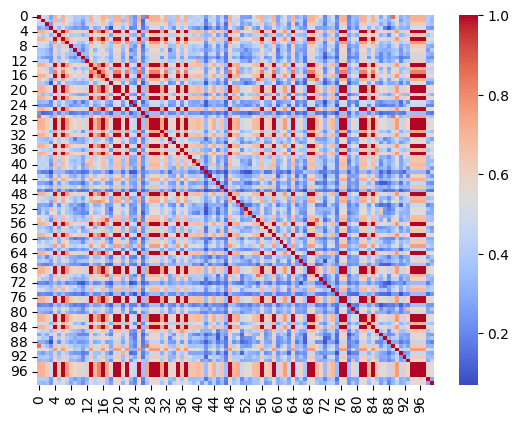

In [28]:
# High Correlation
sns.heatmap(corr1, cmap='coolwarm');

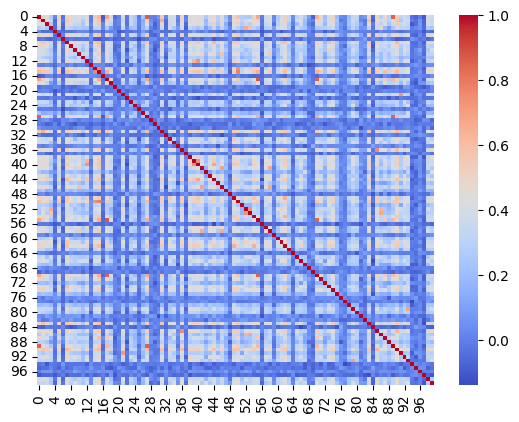

In [29]:
# Low Correlation
sns.heatmap(corr2, cmap='coolwarm');

### Set up CDO object

For a Standard CDO, each bond has a face value of $\$ 100,000$

In [21]:
bond_notionals = np.full(len(lams),100000)

Other CDO Parameters

In [22]:
maturity = 5
r_f = 0.042 # Risk free rate of 4.2%
attachments = np.array([0.0, 0.05, 0.15, 0.25])
runs = 10**5

Create Object

In [23]:
cdo1 = CDO(lams,corr1,maturity,attachments,R,runs,bond_notionals)
cdo2 = CDO(lams,corr2,maturity,attachments,R,runs,bond_notionals)

Examine the Loss Distribution

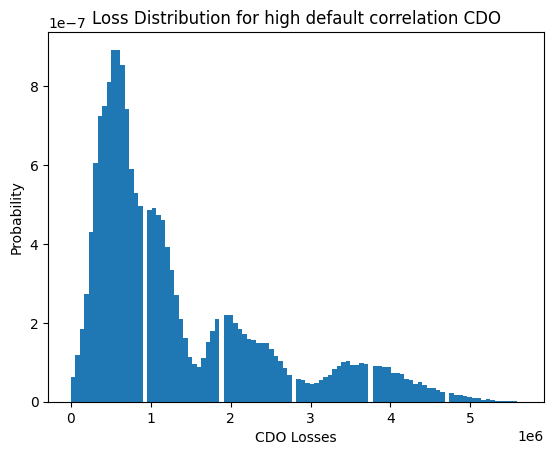

In [24]:
plt.hist(cdo1.payouts,bins=100,density=True,histtype='stepfilled');
plt.xlabel('CDO Losses')
plt.ylabel('Probability')
plt.title('Loss Distribution for high default correlation CDO')
plt.show()

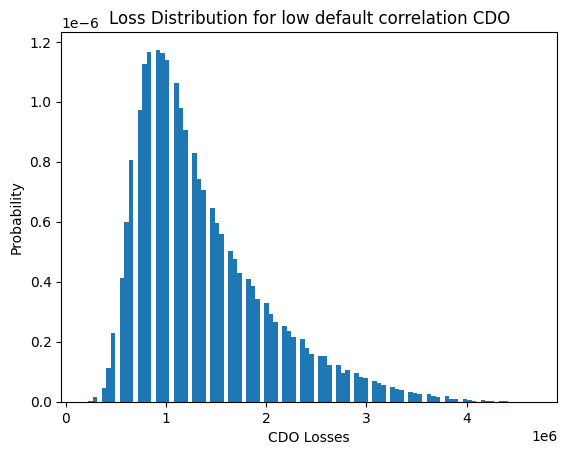

In [25]:
plt.hist(cdo2.payouts,bins=100,density=True,histtype='stepfilled');
plt.xlabel('CDO Losses')
plt.ylabel('Probability')
plt.title('Loss Distribution for low default correlation CDO')
plt.show()

Examine the Protection Spreads for each Tranche

In [26]:
tranche_names = ['Equity', 'Mezzanine', 'Senior', 'Super Senior']
pd.DataFrame(cdo1.spreads*10000,index=tranche_names,columns=['Spread'])

,Spread
Equity,85.517027
Mezzanine,89.470373
Senior,43.214339
Super Senior,30.418092


In [27]:
pd.DataFrame(cdo2.spreads*10000,index=tranche_names,columns=['Spread'])

,Spread
Equity,92.115009
Mezzanine,120.116037
Senior,30.765118
Super Senior,5.877900


# Summary of Results

A CDO with low default correlation among its contituent bonds has a well-behaved loss distribution.

Losses are very likely for the Equity tranche, but the low detachment point means that investors are protected from defaults only up to a limited amount. 

As a result, the fair spread for default protection is lower compared to the Mezzanine tranche.

Losses are still very likely for the Mezzanine tranche, and higher tranche detachment point means that investors are more protected from defaults compared to the Equity tranche.

Losses become less likely at the Senior and Super Senior, and so the fair spread for default protection is lower.

A CDO with high default correlation among its contituent bonds has a multi-modal loss distribution. 

This means the probability of higher losses is elevated compared to the low correlation scenario. As a result, the fair spread for default protection is comparatively higher for the Senior and Super Senior Tranches.